In [252]:
!pip install sweetviz

In [253]:
import pandas as pd
import numpy as np

In [254]:
data = pd.read_csv ('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')


In [255]:
data['is_above_50K'] = data[' <=50K'] == ' >50K'
cols = ['age', 
'workclass', 
'fnlwgt', 
'education', 
'education-num', 
'marital-status', 
'occupation', 
'relationship', 
'race', 
'sex', 
'capital-gain', 
'capital-loss', 
'hours-per-week', 
'native-country', '<=50k', 'is_above_50k'] 

data.columns = cols

In [256]:
!pip install plotly


In [257]:
import plotly.express as px

In [258]:
data['is_above_50k_int'] = np.where (data['is_above_50k'], 1, 0)

**Undersample the data**  
* Need to undersample the majority class to create realisistic links between independent variables.
* If not undersampled, this can lead to majority class over-representing a group that is contributing to the income 
NOTE: explore different ways, such representing data as a ratio

In [259]:
sample_df = data[['education', 	'age', 'sex', 'is_above_50k_int']]
sample_df[sample_df['is_above_50k_int'] == 0].shape

(24719, 4)

In [260]:
sample_df

,education,age,sex,is_above_50k_int
0,Bachelors,50,Male,0
1,HS-grad,38,Male,0
2,11th,53,Male,0
3,Bachelors,28,Female,0
4,Masters,37,Female,0
...,...,...,...,...
32555,Assoc-acdm,27,Female,0
32556,HS-grad,40,Male,1
32557,HS-grad,58,Female,0
32558,HS-grad,22,Male,0


In [261]:
def bargraph(df, varname, over=True, threshold=0.3):
    counts = []
    if over:
        target = " >50K"
    else:
        target = " <=50K"
    vartargets = df[varname].loc[df["income"] == target].value_counts()
    vartargets = vartargets.to_dict()
    varall = df[varname].value_counts()
    varall = varall.to_dict()
    varcats = list(df[varname].unique())#.to_list()
    for v in varcats:
        temptarget = 0
        temptotal = 0
        if v in vartargets:
            temptarget = vartargets[v]
        if v in varall:
            temptotal = varall[v]
        counts.append((v, temptarget, temptotal))
    targetsum = 0
    totalsum = 0
    for i in range(len(counts)):
        targetsum += counts[i][1]
        totalsum += counts[i][2]
        counts[i] = (counts[i][0], counts[i][1]/(counts[i][2]+0.00001))
    list.sort(counts, key=lambda x: x[1])
    varcats = [x[0] for x in counts]
    ratios = np.array([x[1] for x in counts])
    poprate = round(targetsum/totalsum, 4)
    fig,ax = plt.subplots()
    if over:
        colorrate = poprate if poprate > threshold else threshold
        mask = ratios >= colorrate
        colors = ["red" if i else "blue" for i in mask]
    else:
        colorrate = poprate if poprate < threshold else threshold
        mask = ratios >= colorrate
        colors = ["blue" if i else "red" for i in mask]
    bars = ax.bar(varcats, ratios, color=colors)
    for b in bars:
        yval = b.get_height()
        plt.text(b.get_x(), yval+0.02, round(yval*100, 2), size='x-small')
    plt.xticks(range(len(varcats)), varcats, rotation=80)
    plt.plot([-1, len(varcats)], [poprate, poprate], 'g-')
    plt.text(len(varcats)-2.2, poprate+0.002, "Avg Rate {t} = {r}%".format(t = target, r = poprate*100))
    plt.ylabel("Percent earning {}".format(target))
    plt.title("Relative proportions of income by {}".format(varname))
    plt.show()

In [262]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       '<=50k', 'is_above_50k', 'is_above_50k_int'],
      dtype='object')

In [263]:
data['<=50k'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [264]:
data['income'] = data['<=50k']

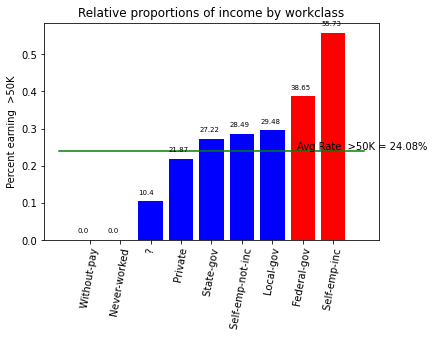

In [265]:
bargraph (data, 'workclass', True)

In [266]:

num_sample = sample_df[sample_df['is_above_50k_int'] == 1].shape[0]

In [267]:
below_50k_df = sample_df[sample_df['is_above_50k_int'] == 0].sample (n=num_sample)
above_50k_df = sample_df[sample_df['is_above_50k_int'] == 1]
data_df = pd.concat ((above_50k_df, below_50k_df))


* According to the plot, higher education contributes strongly to the likelyhood of income over 50K
* Split Ed into 2 groups Bachelors and above and below Bacherlors

In [268]:
parallel_set_df = data_df[['education', 	'age', 'sex', 'is_above_50k_int']].groupby(['education', 	'age', 'sex']).count().reset_index()
parallel_set_df['ED_is_Bachelors_Or_Higher'] = parallel_set_df['education'].apply (lambda x: x in set ([' Bachelors', ' Doctorate', ' Masters', ' Prof-school']))

In [269]:
parallel_set_df['ED_is_Bachelors_Or_Higher'] = parallel_set_df['education'].apply (lambda x: x in set ([' Bachelors', ' Doctorate', ' Masters', ' Prof-school']))

In [270]:
parallel_set_df[parallel_set_df['ED_is_Bachelors_Or_Higher'] == True].shape[0]

375

It looks like there is strong correlation between people between ages 35 and 65 and probability to be above 50K

In [271]:
parallel_set_df['age_btw_35_and_65'] = parallel_set_df['age'].apply (lambda x: (x >= 35) & (x<= 65)  )
parallel_set_df = parallel_set_df[['ED_is_Bachelors_Or_Higher', 'age_btw_35_and_65', 'sex','is_above_50k_int']].drop_duplicates()

In [272]:
fig = px.parallel_categories (parallel_set_df, dimensions=['ED_is_Bachelors_Or_Higher', 'age_btw_35_and_65', 'sex'], color='is_above_50k_int', color_continuous_scale=px.colors.sequential.Inferno)


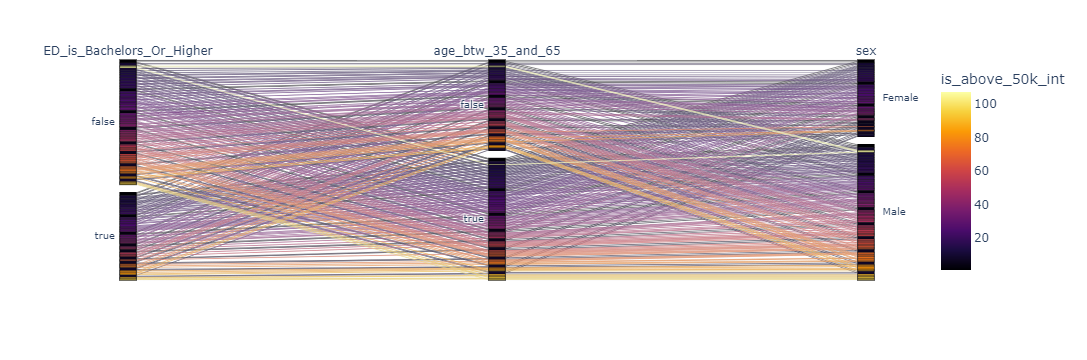

In [273]:
fig.show()

In [274]:
#fig.write_html("parallel_categories_plot.html")
#fig.write_image(f"images/parallel_categories_plot.png")

In [275]:
import pandas as pd

In [276]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,<=50k,is_above_50k,is_above_50k_int,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,False,0,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,False,0,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,False,0,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,False,0,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,False,0,<=50K


In [277]:

data['age'].describe()

count    32560.000000
mean        38.581634
std         13.640642
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [278]:
cats = pd.cut(data['age'], 7, labels=list (range (20, 90, 10)))

In [279]:
age_buckets = cats.value_counts().reset_index()

In [280]:
import matplotlib.pyplot as plt

In [281]:
cats_df = cats.to_frame().rename(columns={'age': 'age_cat'})
data = pd.concat ((data, cats_df), axis=1)

In [282]:
def discretize_continous (df:pd.DataFrame, col:str, step=10):
    min = round(df[col].min() / step) * step
    max = round(df[col].max() / step) * step
    print (f'{min}, {max}')
    lbls = list (range (min, max, step))
    cats = pd.cut(data[col], len(lbls), labels=lbls)
    return cats.value_counts().reset_index()


In [283]:
discretize_continous (data, 'age')

20, 90


,index,age
0,30,8650
1,40,8240
2,20,8031
3,50,4640
4,60,2370
5,70,508
6,80,121


In [284]:
cat_types = ['object', 'str', 'category']
is_categorical = lambda cat: len ( [tp for tp in cat_types if cat == tp]) > 0

In [285]:
'''
cat column - category column that represents category in population. 
 - Only works for categorical variables
'''
def compute_prob_by_category(df: pd.DataFrame, cat_col: str, binary_target_col='is_above_50k_int'):
  if (is_categorical (df.dtypes[cat_col])):
    target_col_prob = f'prob_{binary_target_col}'
    count_prob = 'count_prob'
    columns = [cat_col, target_col_prob, count_prob]
    
    #calculate probability that cat_col is part of the group
    prob_df = df[[cat_col, binary_target_col]].groupby(cat_col).sum() / df[[cat_col, binary_target_col]].groupby(cat_col).count()
    prob_df = prob_df.reset_index().rename(columns={binary_target_col: \
                                                    f'prob_{binary_target_col}'})

    #calculate probability that each category occurs in the distribution for column group
    prob_each_cat_df = df[[cat_col, binary_target_col]].groupby(cat_col).count().reset_index().rename(columns={binary_target_col: 'count'})
    prob_each_cat_df['count_prob'] = prob_each_cat_df['count'] / prob_each_cat_df['count'].sum()
    #merge
    merge_df = pd.merge (prob_df, prob_each_cat_df, on=cat_col)
    return merge_df[columns]
  else:
    raise Exception ("Please provide categorical variable.")
  


Which types are categorical only

In [286]:
[col for col in list (data.columns) if is_categorical(data.dtypes[col]) and col != '<=50k']

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income',
 'age_cat']

In [287]:
marital_status_prob_df = compute_prob_by_category (data, 'marital-status')

In [288]:
marital_status_prob_df.columns

Index(['marital-status', 'prob_is_above_50k_int', 'count_prob'], dtype='object')

In [289]:
import plotly; plotly.__version__

'5.6.0'

In [302]:
import plotly.graph_objects as go
import plotly.io as pio
def plot_prob_histogram (df: pd.DataFrame, cat_col: str, binary_target_col='prob_is_above_50k_int', sort=True):
  '''
  Plot categorical variables and their probability of occurence in target
  '''
  if not sort:
    df.sort_values(by=cat_col, inplace=True)
  else:
    df.sort_values(by=binary_target_col, inplace=True)
  x_line = list (df[cat_col])
  y_line = list (df[binary_target_col])
  x_bar = x_line
  y_bar = list (df['count_prob'])
  fig = go.Figure()
  fig.add_trace (go.Scatter (x=x_line, y=y_line, name='Probability > 50K'))
  fig.add_trace (go.Bar (x=x_bar, y=y_bar, name=cat_col))
  fig.show()
  #fig.write_html(f"{cat_col}_with_prob_over_50k.html")
    

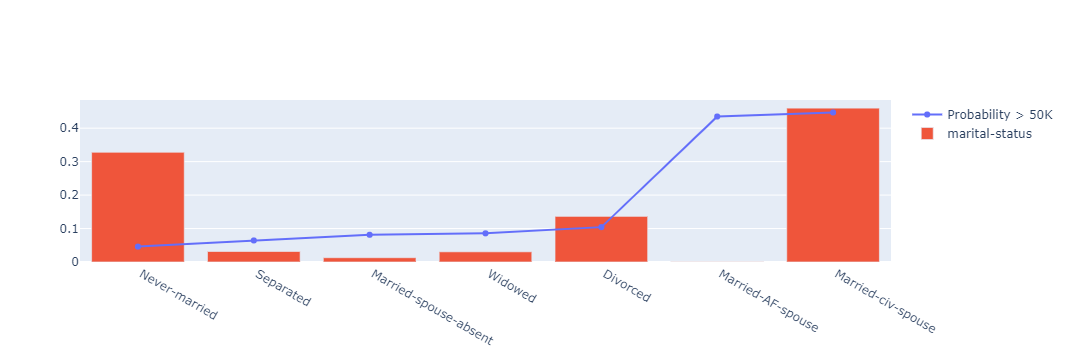

In [291]:
plot_prob_histogram (marital_status_prob_df, 'marital-status')

In [292]:
marital_status_prob_df.columns

Index(['marital-status', 'prob_is_above_50k_int', 'count_prob'], dtype='object')

In [293]:
age_cat_prob_over_50k_df.columns

Index(['age_cat', 'count', 'prob_above_50k', 'count_prob'], dtype='object')

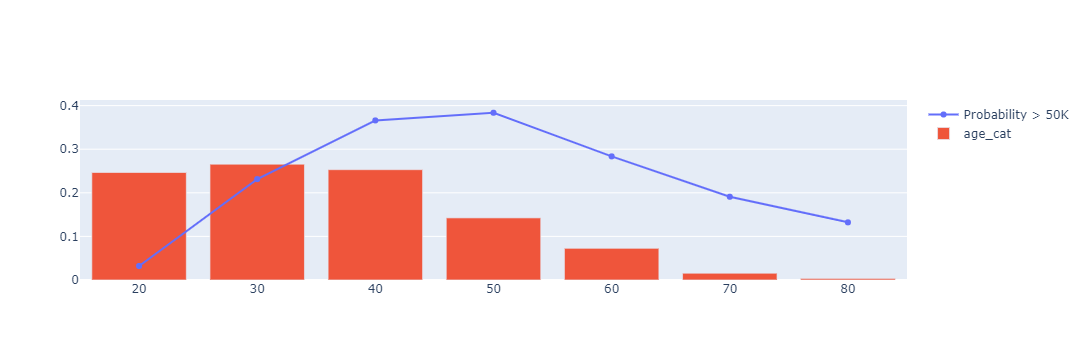

In [303]:
plot_prob_histogram (age_cat_prob_over_50k_df, cat_col='age_cat', binary_target_col='prob_above_50k', sort=False)

In [295]:
def analyze (df, col:str):
  result_df = compute_prob_by_category (df, col)
  plot_prob_histogram (result_df, col)

In [296]:
cat_columns = [col for col in list (data.columns) if is_categorical(data.dtypes[col]) and col != '<=50k']

In [297]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       '<=50k', 'is_above_50k', 'is_above_50k_int', 'income', 'age_cat'],
      dtype='object')

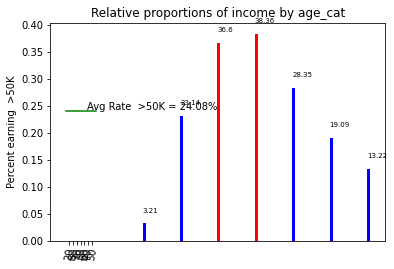

In [298]:
bargraph (data, 'age_cat', True)

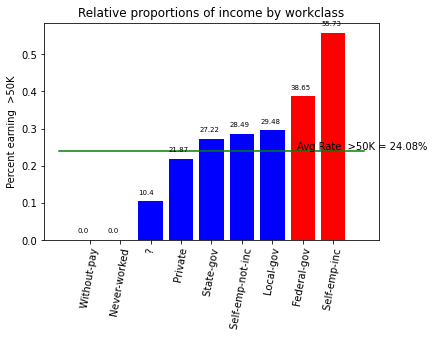

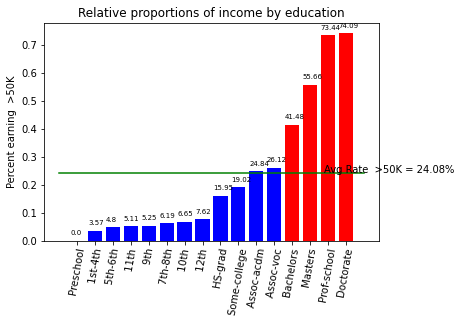

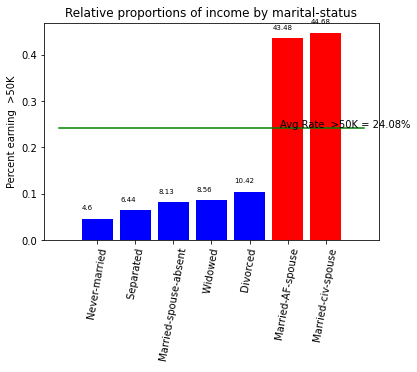

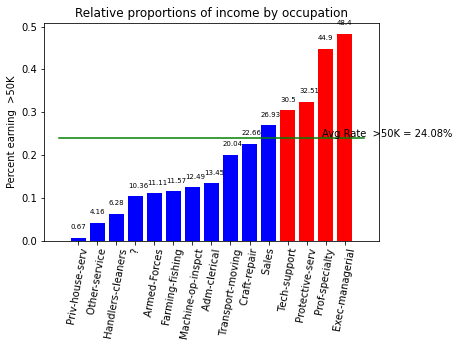

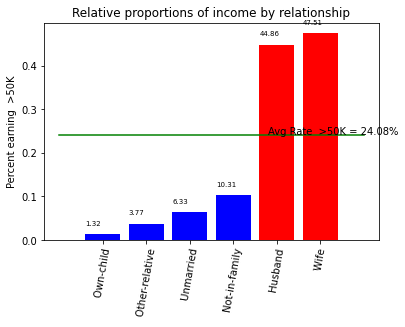

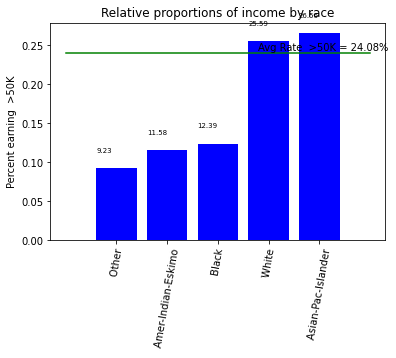

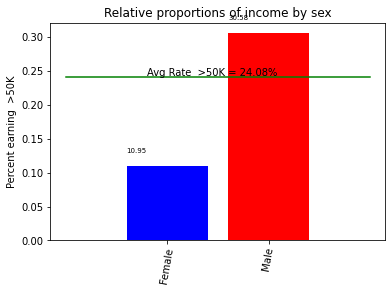

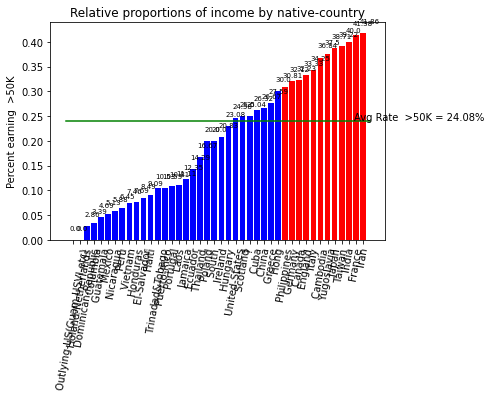

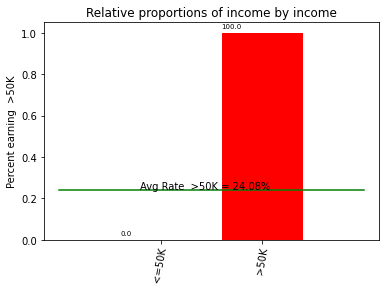

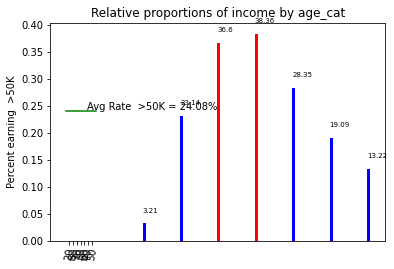

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

In [299]:
pd.Series (cat_columns).apply (lambda cat: bargraph (data, cat, True))

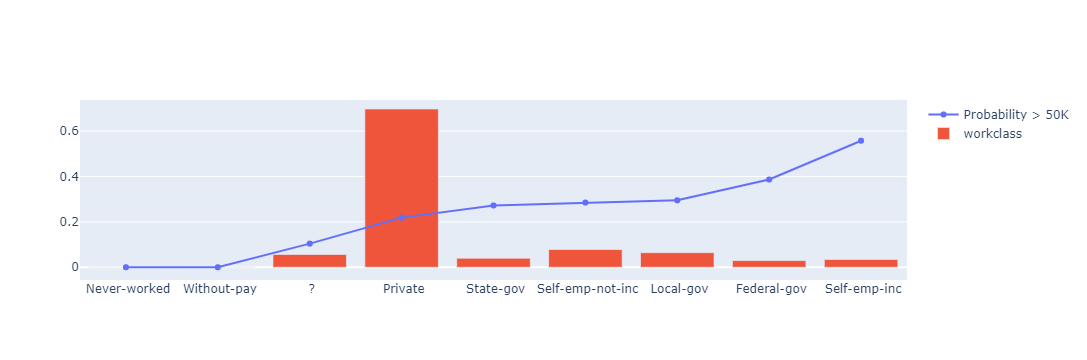

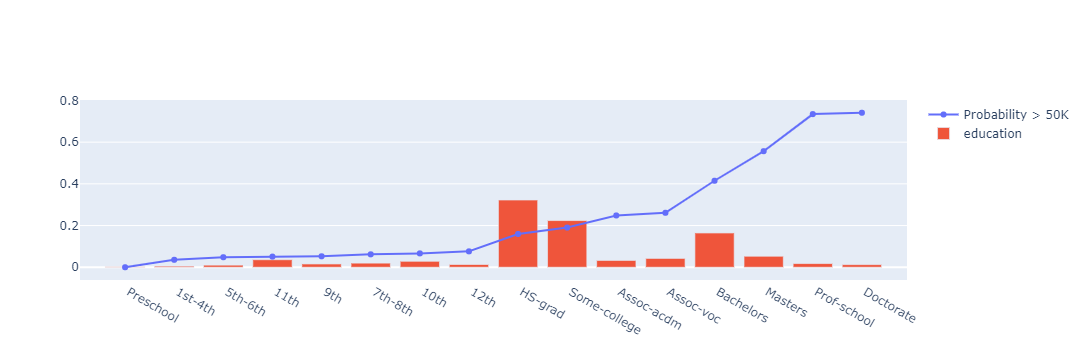

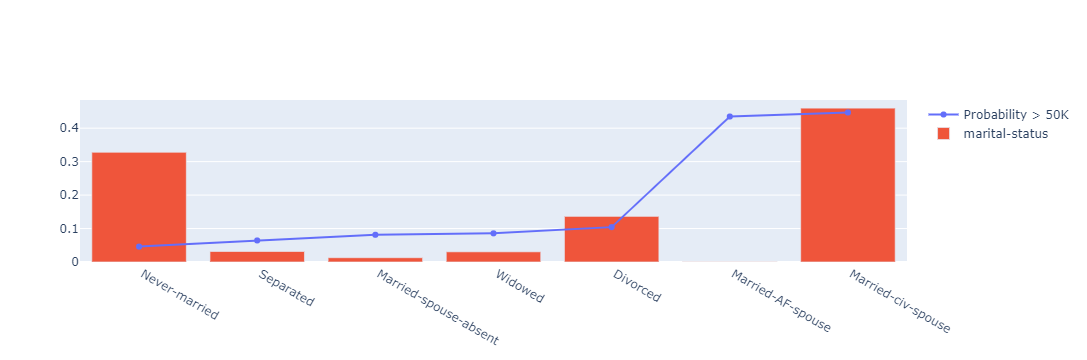

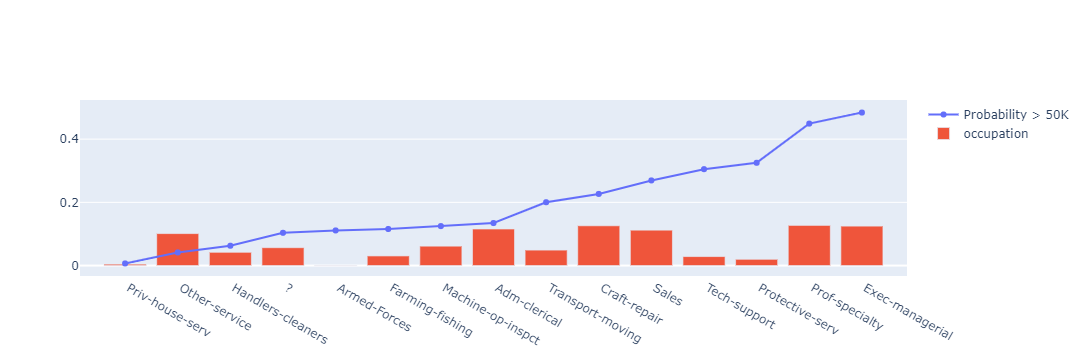

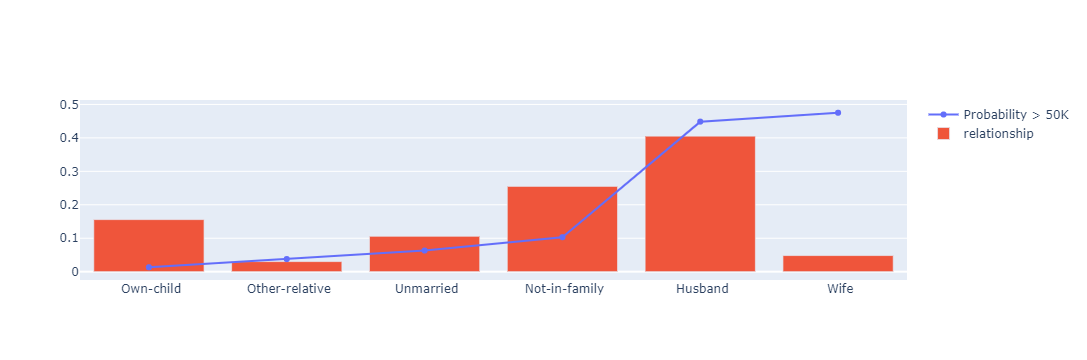

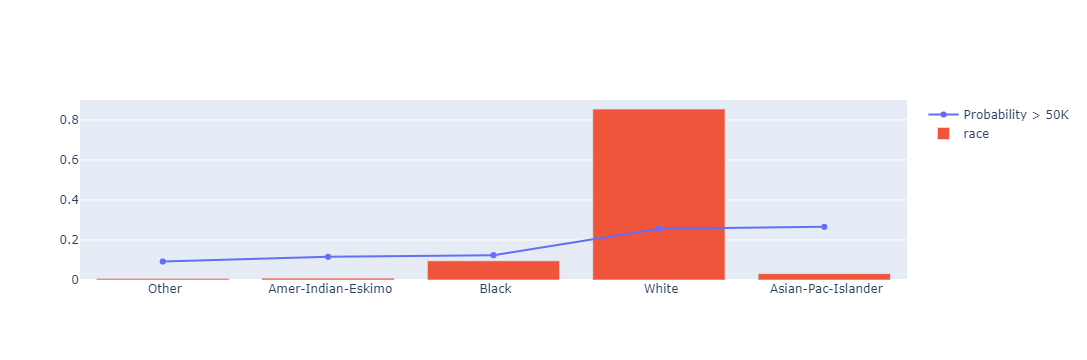

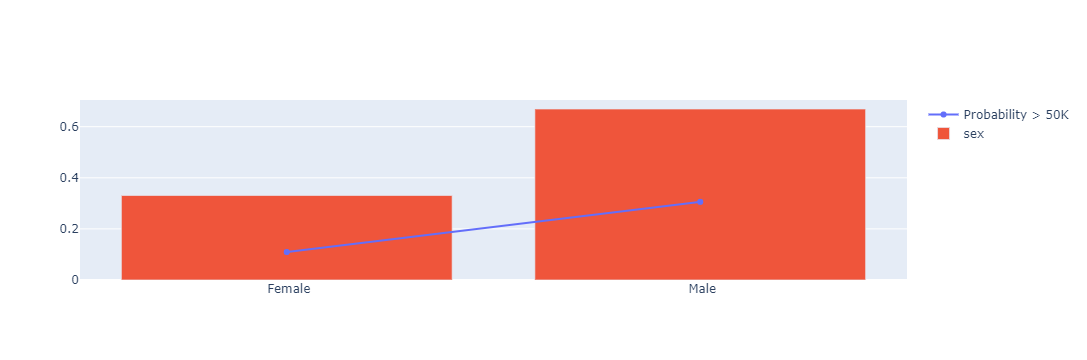

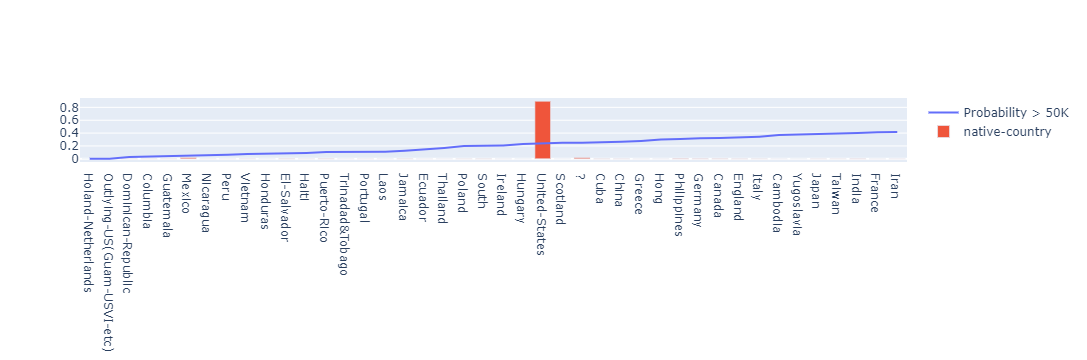

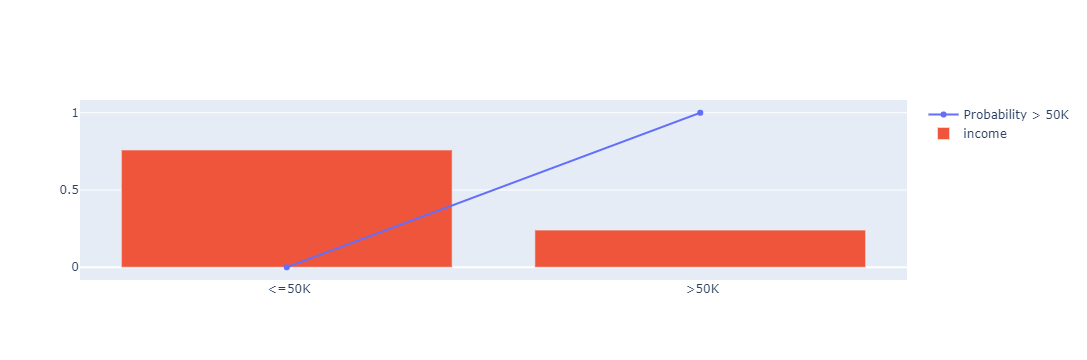

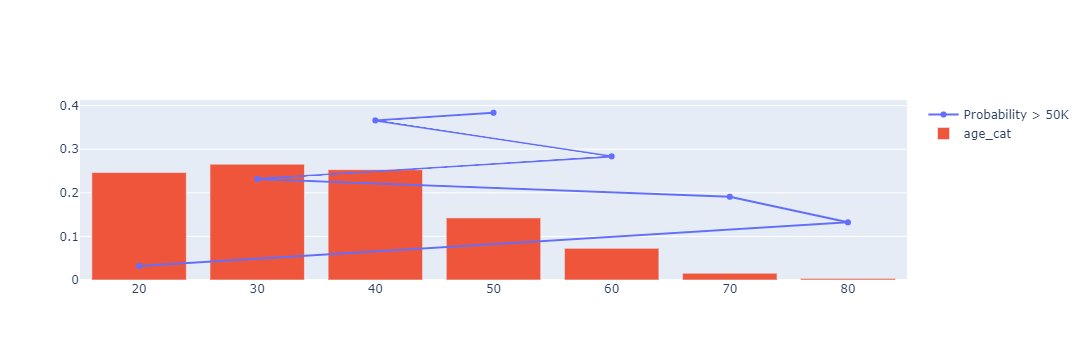

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

In [300]:
pd.Series (cat_columns).apply (lambda cat: analyze (data, cat))